In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`
┌ Info: Precompiling BpAlignGpu [5a3eb610-29b2-4cbe-8ba2-ea97f65fa95d]
└ @ Base loading.jl:1423


In [2]:
T = Float32

Float32

In [3]:
#open("/home/louise/MSA/Data/test/PF00684/")
open("/home/louise/MSA/Data/test/PF00397/")
q = 21; L = 31; 
ctype=Symbol("amino")
typel=Symbol("bm")

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);
J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [4]:
delta = 5;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

println("Consider this sequence: ")
# consider one random sequence as an example
idx0 = 20# rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = BpAlignGpu.Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by HMMer (without and with insertions): ")
println(seqsol)
println(seqins)



Consider this sequence: 
A0A401GBT9_9APHY/8-47
Full length: 
MAPPPLPLGWTEHMSPTGQPYYFNTQTQESTYVRPLPPFP
Aligned by HMMer (without and with insertions): 
LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP
LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP


In [5]:
using DelimitedFiles


In [6]:
#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


muext = 0.00;
muint = 2.50;

In [7]:
q, N, L

(21, 40, 31)

In [8]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=40 q=21]


In [34]:
damp=T(0.1)
tol=T(1e-9)
tolnorm=T(1e-5)
tmax=10
upscheme=:sequential # :random or :sequential
lr=:sce  # :sce or :mf or :sr
beta=T(1.0)
verbose=true
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, lr, beta, verbose)

ParamAlgo{Float32}
-------------
damp=0.1
tol=1.0e-9
tolnorm=1.0e-5
tmax=10
upscheme=sequential
lr=sce
beta=1.0
verbose=true
-------------


In [35]:
bpm = BPMessages(seq, pm)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true]

In [36]:
@time BpAlignGpu.test_sweep!(1,af,pm,pa)

t=1	 err=0.3689094
  0.232065 seconds (44.84 k allocations: 2.511 MiB)


In [37]:
@time BpAlignGpu.test_sweep!(50,af,pm,pa)

t=1	 err=0.14421543
t=2	 err=0.098487556
t=3	 err=0.11653647
t=4	 err=0.40156886
t=5	 err=0.6277066
t=6	 err=0.99855477
t=7	 err=0.9988382
t=8	 err=0.9999244
t=9	 err=0.9989824
t=10	 err=0.9860648
t=11	 err=0.997841
t=12	 err=0.989314
t=13	 err=0.9983787
t=14	 err=0.99576724
t=15	 err=0.15897308
t=16	 err=0.112752005
t=17	 err=0.048441052
t=18	 err=0.024398744
t=19	 err=0.032469567
t=20	 err=0.034692854
t=21	 err=0.04320216
t=22	 err=0.010672629
t=23	 err=0.013447404
t=24	 err=0.008033447
t=25	 err=0.008464292
t=26	 err=0.00939244
t=27	 err=0.008786634
t=28	 err=0.009029031
t=29	 err=0.008864641
t=30	 err=0.008902431
t=31	 err=0.008409645
t=32	 err=0.007983461
t=33	 err=0.010448873
t=34	 err=0.009492397
t=35	 err=0.008919042
t=36	 err=0.008794099
t=37	 err=0.008765817
t=38	 err=0.009048086
t=39	 err=0.008882701
t=40	 err=0.008681357
t=41	 err=0.00873214
t=42	 err=0.009111881
t=43	 err=0.008808494
t=44	 err=0.009397447
t=45	 err=0.009250522
t=46	 err=0.008798361
t=47	 err=0.009300519
t=

In [38]:
findall(isinf.(af.bpb.beliefs)), findall(isnan.(af.bpb.beliefs))

(CartesianIndex{3}[], CartesianIndex{3}[])

In [39]:
findall(isinf.(af.bpb.joint_chain)), findall(isnan.(af.bpb.joint_chain))

(CartesianIndex{5}[], CartesianIndex{5}[])

In [40]:
xnsol, maxbel = BpAlignGpu.solmaxbel(af)
seqpa, seqpo, deb, fin = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)

("LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP", "LPLGWTEHMSPT-GQPYYFNTQTQESTYVRP", 6, 35)

In [41]:
BpAlignGpu.compute_cost_function(pm.J, pm.H, seqpo, L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

(onesite, couplings) = (-4.881430014967918, -53.71831221552566)
(gapcost, inscost) = (2.5f0, 0.0)


┌ Warning: /home/louise/MSA/BpAlignGpu.jl/src/newfun_bpupdate.jl no longer exists, deleted all methods
└ @ Revise /home/louise/.julia/packages/Revise/wjNpr/src/packagedef.jl:651


-56.099743f0

In [42]:
check = BpAlignGpu.check_sr!(xnsol, L, N)
finderrors, errL = findall(x->x==1, check), check[L]

(Int64[], 0)

In [43]:
for i in finderrors
    @show i
    println(xnsol[i-1], ", ", xnsol[i])
end

In [44]:
using Plots, OffsetArrays

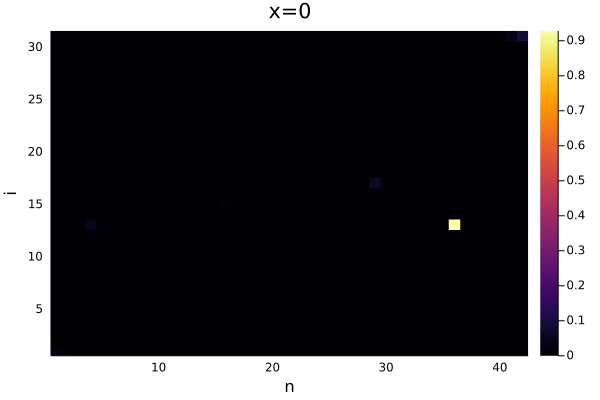

In [45]:
p0 = heatmap(1:42, 1:31, Array(af.bpb.beliefs[:,1,:]), xlabel="n", ylabel="i", title="x=0")

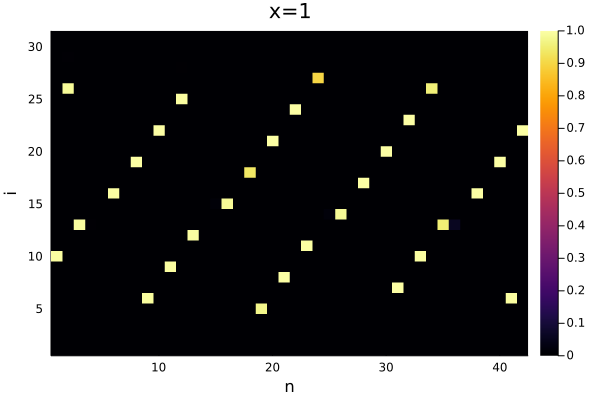

In [46]:
p1 = heatmap(1:42, 1:31, Array(af.bpb.beliefs[:,2,:]), xlabel="n", ylabel="i", title="x=1")

In [47]:
xnsol[1:15]

15-element Vector{Tuple{Int64, Int64}}:
 (1, 6)
 (1, 7)
 (1, 8)
 (1, 9)
 (1, 10)
 (1, 11)
 (1, 12)
 (1, 13)
 (1, 14)
 (1, 15)
 (1, 16)
 (1, 17)
 (0, 17)
 (1, 18)
 (1, 19)

In [48]:
xnsol[16:31]

16-element Vector{Tuple{Int64, Int64}}:
 (1, 20)
 (1, 21)
 (1, 22)
 (1, 23)
 (1, 24)
 (1, 25)
 (1, 26)
 (1, 27)
 (1, 28)
 (1, 29)
 (1, 30)
 (1, 31)
 (1, 32)
 (1, 33)
 (1, 34)
 (1, 35)

In [49]:
P = fill(fill(0.0, 0:1,0:N+1), L)
for i=1:L
    P[i] = OffsetArray(transpose(af.bpb.beliefs[:,:,i]), 0:1,0:N+1)
end
BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L) == BpAlignGpu.decodeposterior(P, seq.strseq)

true

In [50]:
BpAlignGpu.check_assignment(P,true,N)

Let us check the assignment...
The subsequence satisfies the constraints


true

In [52]:
@time BpAlignGpu.update_F!(af, pm, pa)
@time BpAlignGpu.update_hF!(af, pm, pa)
@time BpAlignGpu.update_B!(af, pm, pa)
@time BpAlignGpu.update_hB!(af, pm, pa)
@time BpAlignGpu.update_beliefs!(af, pm, pa)
@time BpAlignGpu.update_jointchain!(af, pm, pa)
@time BpAlignGpu.update_conditional_chain!(af, pa)
@time BpAlignGpu.update_conditional_all!(af, pm)
@time BpAlignGpu.update_f!(af)
@time BpAlignGpu.update_g!(af)

  0.001118 seconds (726 allocations: 45.547 KiB)
  0.001037 seconds (750 allocations: 46.797 KiB)
  0.001018 seconds (726 allocations: 45.703 KiB)
  0.001107 seconds (796 allocations: 49.859 KiB)
  0.000700 seconds (368 allocations: 23.734 KiB)
  0.000785 seconds (441 allocations: 32.203 KiB)
  0.000486 seconds (342 allocations: 19.688 KiB)
  0.034756 seconds (39.15 k allocations: 2.164 MiB)
  0.098424 seconds (302 allocations: 14.922 KiB)
  0.090062 seconds (323 allocations: 16.828 KiB)
